# Adding Primary Location to individuals

After assigning an activity chain to each individual, we then need to map these activities to geographic locations. We start with primary locations (work, school) and fill in the gaps later with discretionary locations. This notebook will focus on the primary locations.

We follow the steps outlined in this [github issue](https://github.com/Urban-Analytics-Technology-Platform/acbm/issues/12)

In [1]:
import logging
import pickle as pkl

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from shapely.geometry import Point

from acbm.assigning import (
    fill_missing_zones,
    get_activities_per_zone,
    get_possible_zones,
    select_zone,
    zones_to_time_matrix,
)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Load in the data


### Activity chains

In [2]:
# read parquet file
activity_chains = pd.read_parquet('../data/interim/matching/spc_with_nts_trips.parquet')
activity_chains.head(10)

,id,household,location,pid_hs,msoa,oa,members,sic1d2007,sic2d2007,pwkstat,...,TripStart,TripEnd,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,TripOrigGOR_B02ID,TripDestGOR_B02ID,W5,W5xHH
0,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,...,330.0,345.0,10.0,10.0,15.0,15.0,8.0,8.0,0.680422,1.000000
1,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,...,885.0,900.0,10.0,10.0,15.0,15.0,8.0,8.0,0.680422,1.000000
2,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,...,330.0,345.0,10.0,10.0,15.0,15.0,8.0,8.0,0.727735,1.069535
3,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,...,795.0,810.0,10.0,10.0,15.0,15.0,8.0,8.0,0.727735,1.069535
4,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,...,480.0,540.0,10.0,10.0,60.0,60.0,8.0,8.0,0.758707,1.115053
5,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,...,540.0,600.0,10.0,10.0,60.0,60.0,8.0,8.0,0.758707,1.115053
6,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,...,720.0,750.0,1.5,1.5,30.0,30.0,8.0,8.0,0.758707,1.115053
7,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,...,750.0,780.0,1.5,1.5,30.0,30.0,8.0,8.0,0.758707,1.115053
8,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,...,900.0,910.0,4.0,4.0,10.0,10.0,8.0,8.0,0.765863,1.125570
9,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,...,960.0,970.0,4.0,4.0,10.0,10.0,8.0,8.0,0.765863,1.125570


#### Data preparation: Mapping trip purposes

Rename columns and map actual modes and trip purposes to the trip table. 

Code taken from: https://github.com/arup-group/pam/blob/main/examples/07_travel_survey_to_matsim.ipynb

In [3]:
activity_chains = activity_chains.rename(
    columns={  # rename data
        "JourSeq": "seq",
        "TripOrigGOR_B02ID": "ozone",
        "TripDestGOR_B02ID": "dzone",
        "TripPurpFrom_B01ID": "oact",
        "TripPurpTo_B01ID": "dact",
        "MainMode_B04ID": "mode",
        "TripStart": "tst",
        "TripEnd": "tet",
    }
)

Check the NTS glossary [here](https://www.gov.uk/government/statistics/national-travel-survey-2022-technical-report/national-travel-survey-2022-technical-report-glossary) to understand what the trip purposes mean.

add an escort column

In [4]:
mode_mapping = {
    1: "walk",
    2: "cycle",
    3: "car",  #'Car/van driver'
    4: "car",  #'Car/van driver'
    5: "car",  #'Motorcycle',
    6: "car",  #'Other private transport',
    7: "pt",  # Bus in London',
    8: "pt",  #'Other local bus',
    9: "pt",  #'Non-local bus',
    10: "pt",  #'London Underground',
    11: "pt",  #'Surface Rail',
    12: "car",  #'Taxi/minicab',
    13: "pt",  #'Other public transport',
    -10: "DEAD",
    -8: "NA",
}

purp_mapping = {
    1: "work",
    2: "work",  #'In course of work',
    3: "education",
    4: "shop_food",  #'Food shopping',
    5: "shop_other",  #'Non food shopping',
    6: "medical",  #'Personal business medical',
    7: "other_eat_drink",  #'Personal business eat/drink',
    8: "other",  #'Personal business other',
    9: "other_eat_drink",  #'Eat/drink with friends',
    10: "visit",  #'Visit friends',
    11: "other_social",  #'Other social',
    12: "other",  #'Entertain/ public activity',
    13: "other_sport",  #'Sport: participate',
    14: "home",  #'Holiday: base',
    15: "other",  #'Day trip/just walk',
    16: "other",  #'Other non-escort',
    17: "escort_home",  #'Escort home',
    18: "escort_work",  #'Escort work',
    19: "escort_work",  #'Escort in course of work',
    20: "escort_education",  #'Escort education',
    21: "escort_shopping",  #'Escort shopping/personal business',
    22: "escort",  #'Other escort',
    23: "home",  #'Home',
    -10: "DEAD",
    -8: "NA",
}


activity_chains["mode"] = activity_chains["mode"].map(mode_mapping)

activity_chains["oact"] = activity_chains["oact"].map(purp_mapping)

activity_chains["dact"] = activity_chains["dact"].map(purp_mapping)

### Study area boundaries

In [5]:
boundaries = gpd.read_file('../data/external/boundaries/oa_england.geojson')
boundaries.head(10)

,OBJECTID,OA21CD,GlobalID,LSOA21CD,LSOA21NM,MSOA21CD,MSOA21NM,LEP22CD1,LEP22NM1,LAD22CD,LAD22NM,rgn22cd,rgn22nm,ctry22cd,ctry22nm,geometry
0,1,E00000001,bc5eb21b-d42b-4715-a771-2c27575a08f0,E01000001,City of London 001A,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532303.492 181814.110, 532213...."
1,2,E00000003,a1a2b34f-320e-4bb8-acb4-7ca7ca16ef9c,E01000001,City of London 001A,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532213.378 181846.192, 532190...."
2,3,E00000005,9337da1a-fe0f-4210-9c95-ed2d20fd6287,E01000001,City of London 001A,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532180.131 181763.020, 532219...."
3,4,E00000007,b336e11f-af26-48a6-ac67-44f5b8b8840a,E01000001,City of London 001A,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532201.292 181668.180, 532267...."
4,5,E00000010,ca8f9874-cdf5-4c1a-9d39-f74a410dae44,E01000003,City of London 001C,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532127.958 182133.192, 532089...."
5,6,E00000013,b9b93246-bbfb-46af-8011-6b8ed5908956,E01000003,City of London 001C,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532247.654 181897.577, 532248...."
6,7,E00000018,fcb7c232-4165-44da-8ff8-b6cc383b528a,E01000002,City of London 001B,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532440.197 181842.934, 532544...."
7,8,E00000019,715e0851-2375-4d6a-94ac-532ba0833c60,E01000002,City of London 001B,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532619.141 181847.188, 532603...."
8,9,E00000020,4251a2ff-8fbe-4c11-aece-044f23ab9af2,E01000002,City of London 001B,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532515.000 181686.981, 532544...."
9,10,E00000021,48b2df49-45ed-48a4-b7fc-e0e32c1ad088,E01000002,City of London 001B,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532746.813 181786.891, 532671...."


In [6]:
# filter to only include the OA's where "Leeds" is in the MSOA21NM field
boundaries = boundaries[boundaries['MSOA21NM'].str.contains("Leeds", na=False)]

<Axes: >

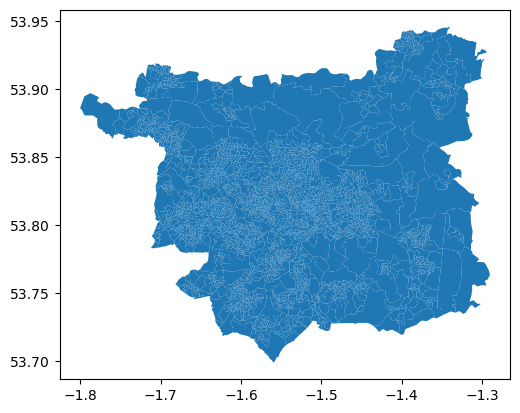

In [7]:
# convert boundaries to 4326
boundaries = boundaries.to_crs(epsg=4326)
# plot the geometry
boundaries.plot()

In [8]:
boundaries.head(10)

,OBJECTID,OA21CD,GlobalID,LSOA21CD,LSOA21NM,MSOA21CD,MSOA21NM,LEP22CD1,LEP22NM1,LAD22CD,LAD22NM,rgn22cd,rgn22nm,ctry22cd,ctry22nm,geometry
53506,53507,E00056750,0fd0c6c3-be95-44c9-ae9b-5046e36644d3,E01011269,Leeds 011B,E02002340,Leeds 011,E37000062,Leeds City Region,E08000035,Leeds,E12000003,Yorkshire and The Humber,E92000001,England,"MULTIPOLYGON (((-1.68707 53.86901, -1.68740 53..."
53507,53508,E00056751,358b1d5c-1301-4913-9270-f93a104a7e01,E01011272,Leeds 009D,E02002338,Leeds 009,E37000062,Leeds City Region,E08000035,Leeds,E12000003,Yorkshire and The Humber,E92000001,England,"MULTIPOLYGON (((-1.70055 53.86613, -1.70060 53..."
53508,53509,E00056752,8ed9b868-29c2-404d-9fa4-58b5a2481f8f,E01011273,Leeds 010B,E02002339,Leeds 010,E37000062,Leeds City Region,E08000035,Leeds,E12000003,Yorkshire and The Humber,E92000001,England,"MULTIPOLYGON (((-1.69351 53.86904, -1.69372 53..."
53509,53510,E00056753,33fe3f5a-898c-41f6-8b42-9d8a5276a275,E01011274,Leeds 010C,E02002339,Leeds 010,E37000062,Leeds City Region,E08000035,Leeds,E12000003,Yorkshire and The Humber,E92000001,England,"MULTIPOLYGON (((-1.68013 53.86747, -1.68026 53..."
53510,53511,E00056754,8d53d2d4-ca6a-4ddb-9d2a-9dd66bdcf42c,E01011276,Leeds 011C,E02002340,Leeds 011,E37000062,Leeds City Region,E08000035,Leeds,E12000003,Yorkshire and The Humber,E92000001,England,"MULTIPOLYGON (((-1.67750 53.86496, -1.67755 53..."
53511,53512,E00056755,0d97ece5-e0e7-4e83-9237-730a5863b686,E01011274,Leeds 010C,E02002339,Leeds 010,E37000062,Leeds City Region,E08000035,Leeds,E12000003,Yorkshire and The Humber,E92000001,England,"MULTIPOLYGON (((-1.68652 53.86448, -1.68663 53..."
53512,53513,E00056756,50be522b-5687-4538-8d86-72eb73133fcb,E01011274,Leeds 010C,E02002339,Leeds 010,E37000062,Leeds City Region,E08000035,Leeds,E12000003,Yorkshire and The Humber,E92000001,England,"MULTIPOLYGON (((-1.68460 53.86178, -1.68507 53..."
53513,53514,E00056757,9ec0e325-dd79-4a8a-b886-18d5127ee5f7,E01011276,Leeds 011C,E02002340,Leeds 011,E37000062,Leeds City Region,E08000035,Leeds,E12000003,Yorkshire and The Humber,E92000001,England,"MULTIPOLYGON (((-1.68077 53.86111, -1.68022 53..."
53514,53515,E00056758,a5138f04-7856-413c-8abb-fb3369dff319,E01011277,Leeds 014A,E02002343,Leeds 014,E37000062,Leeds City Region,E08000035,Leeds,E12000003,Yorkshire and The Humber,E92000001,England,"MULTIPOLYGON (((-1.69477 53.86197, -1.69533 53..."
53515,53516,E00056759,772cb09b-1bdc-4cc9-8b26-9032b235e9d8,E01011277,Leeds 014A,E02002343,Leeds 014,E37000062,Leeds City Region,E08000035,Leeds,E12000003,Yorkshire and The Humber,E92000001,England,"MULTIPOLYGON (((-1.70129 53.86019, -1.70077 53..."


#### Assign activity home locations to boundaries zoning system 

Convert location column in activity_chains to spatial column

In [9]:
# turn column to shapely point
activity_chains['location'] = activity_chains['location'].apply(lambda loc: Point(loc['x'], loc['y']))

# Convert the DataFrame into a GeoDataFrame, and assign a coordinate reference system (CRS)
activity_chains = gpd.GeoDataFrame(activity_chains, geometry='location')
activity_chains.crs = "EPSG:4326" # I assume this is the crs


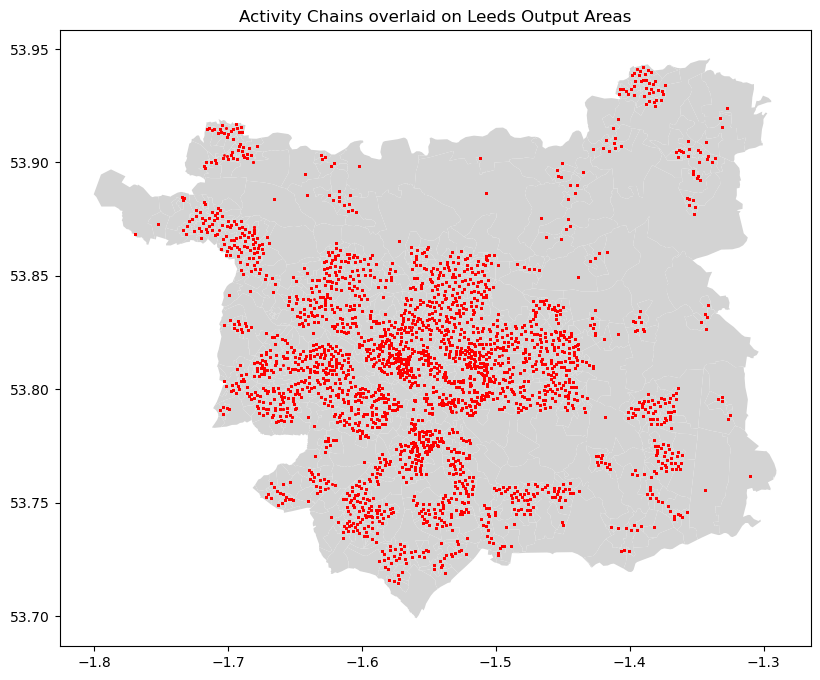

In [10]:
# plot the boundaries gdf and overlay them with the activity_chains gdf
fig, ax = plt.subplots(figsize=(10, 8))
boundaries.plot(ax=ax, color='lightgrey')
activity_chains.plot(ax=ax, color='red', markersize=1)
plt.title('Activity Chains overlaid on Leeds Output Areas')
plt.show()


In [11]:
#remove index_right column from activity_chains if it exists
if 'index_right' in activity_chains.columns:
    activity_chains = activity_chains.drop(columns='index_right')


# Spatial join to identify which polygons each point is in
activity_chains = gpd.sjoin(activity_chains, boundaries[["OA21CD", "geometry"]], how='left', predicate='within')
activity_chains = activity_chains.drop('index_right', axis=1)


### Travel time matrix for study area

Travel time data between geographical areas (LSOA, OA, custom hexagons etc) is used to determine feasible work / school locations for each individual. The travel times are compared to the travel times of the individual's actual trips from the nts (`tst`/`TripStart` and `tet`/`TripEnd`)

In [12]:
travel_times = pd.read_parquet('../data/external/travel_times/oa/travel_time_matrix_acbm.parquet')
travel_times.head(10)

,from_id,to_id,travel_time_p25,travel_time_p50,travel_time_p75,combination
0,53507,53507,0,0.0,0.0,pt_wkday_morning
1,53507,53508,24,29.0,34.0,pt_wkday_morning
2,53507,53509,17,22.0,27.0,pt_wkday_morning
3,53507,53510,12,14.0,16.0,pt_wkday_morning
4,53507,53511,14,16.0,18.0,pt_wkday_morning
5,53507,53512,10,10.0,10.0,pt_wkday_morning
6,53507,53513,11,13.0,15.0,pt_wkday_morning
7,53507,53514,23,25.0,28.0,pt_wkday_morning
8,53507,53515,31,36.0,41.0,pt_wkday_morning
9,53507,53516,34,39.0,44.0,pt_wkday_morning


In [13]:
travel_times["combination"].unique()

array(['pt_wkday_morning', 'pt_wkday_afternoon', 'pt_wkday_evening',
       'pt_wkday_night', 'pt_wkend_morning', 'pt_wkend_evening', 'car',
       'walk', 'cycle'], dtype=object)

Add area code to travel time data

In [14]:
# convert from_id and to_id to int to match the boundaries data type
travel_times = travel_times.astype({'from_id': int, 'to_id': int})

# merge travel_times with boundaries
travel_times = travel_times.merge(boundaries[['OBJECTID', 'OA21CD']], left_on='from_id', right_on='OBJECTID', how='left')
travel_times = travel_times.drop(columns='OBJECTID')

travel_times = travel_times.merge(boundaries[['OBJECTID', 'OA21CD']], left_on='to_id', right_on='OBJECTID', how='left', suffixes=('_from', '_to'))
travel_times = travel_times.drop(columns='OBJECTID')

travel_times.head(10)

,from_id,to_id,travel_time_p25,travel_time_p50,travel_time_p75,combination,OA21CD_from,OA21CD_to
0,53507,53507,0,0.0,0.0,pt_wkday_morning,E00056750,E00056750
1,53507,53508,24,29.0,34.0,pt_wkday_morning,E00056750,E00056751
2,53507,53509,17,22.0,27.0,pt_wkday_morning,E00056750,E00056752
3,53507,53510,12,14.0,16.0,pt_wkday_morning,E00056750,E00056753
4,53507,53511,14,16.0,18.0,pt_wkday_morning,E00056750,E00056754
5,53507,53512,10,10.0,10.0,pt_wkday_morning,E00056750,E00056755
6,53507,53513,11,13.0,15.0,pt_wkday_morning,E00056750,E00056756
7,53507,53514,23,25.0,28.0,pt_wkday_morning,E00056750,E00056757
8,53507,53515,31,36.0,41.0,pt_wkday_morning,E00056750,E00056758
9,53507,53516,34,39.0,44.0,pt_wkday_morning,E00056750,E00056759


#### Travel distance matrix

Some areas aren't reachable by specific modes. This can cause problems later on in get_possible_zones() as we won't be able to assign some activities to zones. We create a travel distance matrix to fall back on when there are no travel time calculations

In [15]:
travel_time_estimates = zones_to_time_matrix(
    zones = boundaries,
    id_col = "OA21CD",
    to_dict = True
)

travel_time_estimates

{('E00056750', 'E00056750'): {'distance': 0.0,
  'time_car': 0.0,
  'time_pt': 0.0,
  'time_cycle': 0.0,
  'time_walk': 0.0,
  'time_average': 0.0},
 ('E00056750', 'E00056751'): {'distance': 1094.6936246851778,
  'time_car': 197.04485244333202,
  'time_pt': 262.72646992444265,
  'time_cycle': 262.72646992444265,
  'time_walk': 788.1794097733281,
  'time_average': 262.72646992444265},
 ('E00056750', 'E00056752'): {'distance': 507.0518272579844,
  'time_car': 91.2693289064372,
  'time_pt': 121.69243854191626,
  'time_cycle': 121.69243854191626,
  'time_walk': 365.0773156257488,
  'time_average': 121.69243854191626},
 ('E00056750', 'E00056753'): {'distance': 438.18052839269427,
  'time_car': 78.87249511068497,
  'time_pt': 105.16332681424662,
  'time_cycle': 105.16332681424662,
  'time_walk': 315.48998044273986,
  'time_average': 105.16332681424662},
 ('E00056750', 'E00056754'): {'distance': 672.107062011398,
  'time_car': 120.97927116205166,
  'time_pt': 161.3056948827355,
  'time_cycle'

In [16]:
with open('../data/interim/assigning/travel_time_estimates.pkl', 'wb') as f:
    pkl.dump(travel_time_estimates, f)

### Activity locations 

Activity locations are obtained from OSM using the [osmox](https://github.com/arup-group/osmox) package. Check the config documentation in the package and the `config_osmox` file in this repo

In [17]:
# osm data
osm_data = gpd.read_parquet('../data/external/boundaries/west-yorkshire_epsg_4326.parquet')

In [18]:
osm_data.head(100)

,id,activities,geometry,units,levels,area,floor_area,distance_to_nearest_transit,distance_to_nearest_shop,distance_to_nearest_medical
0,643657,transit,POINT (-1.50849 53.76233),1.0,1.0,0,0.0,0.000000,109.755337,1883.754159
1,20621535,home,POINT (-1.56566 53.81375),1.0,2.0,0,0.0,198.493258,108.072976,255.853754
2,21591858,home,POINT (-1.63279 53.87138),1.0,2.0,0,0.0,969.484065,509.809989,2318.285507
3,27325240,transit,POINT (-1.66533 53.90971),1.0,1.0,0,0.0,0.000000,578.769135,1673.801938
4,27348238,transit,POINT (-1.63022 53.90354),1.0,1.0,0,0.0,0.000000,95.392235,3927.514412
...,...,...,...,...,...,...,...,...,...,...
95,52866056,transit,POINT (-1.54816 53.81696),1.0,1.0,0,0.0,0.000000,48.379183,317.881874
96,52866068,transit,POINT (-1.54590 53.81564),1.0,1.0,0,0.0,0.000000,38.926766,190.788417
97,52866109,transit,POINT (-1.54388 53.81031),1.0,1.0,0,0.0,0.000000,144.888621,359.126778
98,52866124,transit,POINT (-1.54084 53.80800),1.0,1.0,0,0.0,0.000000,66.565162,262.559075


In [19]:
# get unique values for activties column
osm_data['activities'].unique()

array(['transit', 'home', 'work,shop', 'work,other', 'other',
       'medical,work', 'work,education_university', 'work',
       'home,education_school,work', 'shop,work,visit',
       'work,education_college', 'work,visit', 'shop,work',
       'work,education_kg', 'shop,other,work',
       'shop,other,visit,medical,work', 'education_school,work',
       'shop,visit,work', 'other,shop,visit,work',
       'shop,other,visit,work',
       'shop,other,visit,education_university,work', 'shop,home,work',
       'home,work', 'home,work,education_kg',
       'education_school,work,education_kg', 'work,other,shop',
       'medical,work,visit', 'work,education_university,other',
       'shop,work,education_kg', 'shop,work,other',
       'shop,education_college,visit,work', 'shop,visit,medical,work',
       'work,home,shop', 'work,shop,visit',
       'work,education_school,education_college',
       'work,education_school,shop', 'home,medical,work',
       'shop,medical,work', 'other,shop,work', 

In [20]:
# remove rows with activities = home

osm_data = osm_data[osm_data['activities'] != 'home']
osm_data.head(100)

,id,activities,geometry,units,levels,area,floor_area,distance_to_nearest_transit,distance_to_nearest_shop,distance_to_nearest_medical
0,643657,transit,POINT (-1.50849 53.76233),1.0,1.0,0,0.0,0.000000,109.755337,1883.754159
3,27325240,transit,POINT (-1.66533 53.90971),1.0,1.0,0,0.0,0.000000,578.769135,1673.801938
4,27348238,transit,POINT (-1.63022 53.90354),1.0,1.0,0,0.0,0.000000,95.392235,3927.514412
8,27475939,"work,shop",POINT (-1.38550 53.92917),1.0,1.0,0,0.0,13.691226,0.000000,276.210958
9,27563268,transit,POINT (-1.71095 53.91335),1.0,1.0,0,0.0,0.000000,521.696581,653.499530
...,...,...,...,...,...,...,...,...,...,...
100,52866138,transit,POINT (-1.53947 53.80003),1.0,1.0,0,0.0,0.000000,26.294032,66.891230
101,52866141,transit,POINT (-1.57484 53.82608),1.0,1.0,0,0.0,0.000000,365.934113,387.315207
102,52871164,transit,POINT (-1.54835 53.80340),1.0,1.0,0,0.0,0.000000,139.303622,189.701320
103,52871167,transit,POINT (-1.54917 53.80167),1.0,1.0,0,0.0,0.000000,96.458170,108.081829


In [21]:
osm_data.activities.unique()

array(['transit', 'work,shop', 'work,other', 'other', 'medical,work',
       'work,education_university', 'work', 'home,education_school,work',
       'shop,work,visit', 'work,education_college', 'work,visit',
       'shop,work', 'work,education_kg', 'shop,other,work',
       'shop,other,visit,medical,work', 'education_school,work',
       'shop,visit,work', 'other,shop,visit,work',
       'shop,other,visit,work',
       'shop,other,visit,education_university,work', 'shop,home,work',
       'home,work', 'home,work,education_kg',
       'education_school,work,education_kg', 'work,other,shop',
       'medical,work,visit', 'work,education_university,other',
       'shop,work,education_kg', 'shop,work,other',
       'shop,education_college,visit,work', 'shop,visit,medical,work',
       'work,home,shop', 'work,shop,visit',
       'work,education_school,education_college',
       'work,education_school,shop', 'home,medical,work',
       'shop,medical,work', 'other,shop,work', 'work,other,vis

#### Get the number of activities in each zone 

Each zone has a different number of education facilities. We can use the number of facilities in each zone to determine the probability of each zone being chosen for each trip. We can then use these probabilities to randomly assign a zone to each trip.

The education facilities are disaggregated by type. For each activity, we use the individual's age to detemrine which of the following they are most likely to go to 

- "kindergarden": education_kg"
- "school": "education_school"
- "university": "education_university"
- "college": "education_college"

In [22]:
# spatial join to identify which zone each point in osm_data is in
osm_data_gdf = gpd.sjoin(osm_data, boundaries[["OA21CD", "geometry"]], how='inner', predicate='within')
osm_data_gdf.head(5)

,id,activities,geometry,units,levels,area,floor_area,distance_to_nearest_transit,distance_to_nearest_shop,distance_to_nearest_medical,index_right,OA21CD
0,643657,transit,POINT (-1.50849 53.76233),1.0,1.0,0,0.0,0.000000,109.755337,1883.754159,54486,E00057792
3,27325240,transit,POINT (-1.66533 53.90971),1.0,1.0,0,0.0,0.000000,578.769135,1673.801938,55010,E00058347
4,27348238,transit,POINT (-1.63022 53.90354),1.0,1.0,0,0.0,0.000000,95.392235,3927.514412,55048,E00058385
8,27475939,"work,shop",POINT (-1.38550 53.92917),1.0,1.0,0,0.0,13.691226,0.000000,276.210958,55654,E00059036
9,27563268,transit,POINT (-1.71095 53.91335),1.0,1.0,0,0.0,0.000000,521.696581,653.499530,55037,E00058374


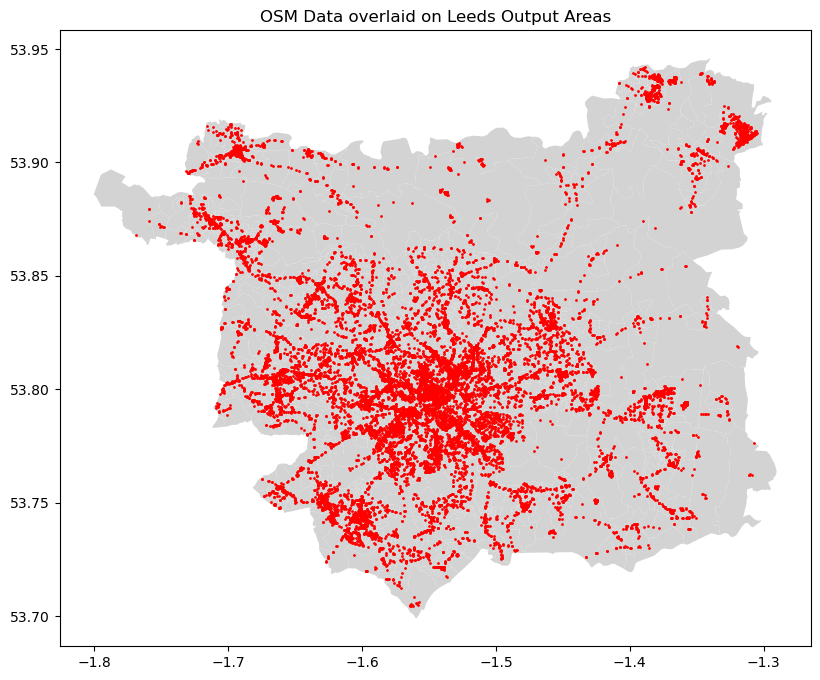

In [23]:
# plot the points and then plot the zones on a map
fig, ax = plt.subplots(figsize=(10, 8))
boundaries.plot(ax=ax, color='lightgrey')
osm_data_gdf.plot(ax=ax, color='red', markersize=1)
plt.title('OSM Data overlaid on Leeds Output Areas')
plt.show()

Let's check if we can use floor area as a weight when sampling a region / a school

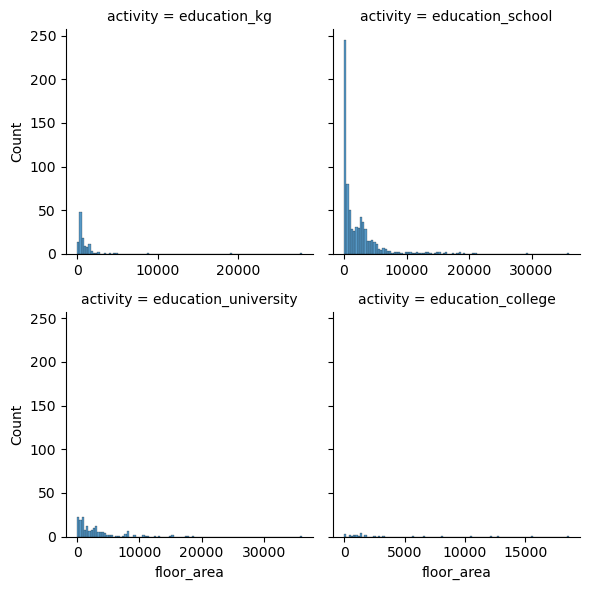

In [24]:
# plot the distribution of floor area for rows where activities includes "education_"


# List of activity types
activity_types = ['education_kg', 'education_school', 'education_university', 'education_college']

# Initialize a list to store DataFrames
df_list = []

# For each activity type, filter the rows where activities includes the activity type, and append to df_list
for activity in activity_types:
    temp_df = osm_data_gdf[osm_data_gdf['activities'].apply(lambda x: activity in x)][['floor_area']].copy()
    temp_df['activity'] = activity
    df_list.append(temp_df)

# Concatenate all the DataFrames in df_list
df = pd.concat(df_list)

# Create a FacetGrid
g = sns.FacetGrid(df, col="activity", col_wrap=2, sharex=False)
g.map(sns.histplot, "floor_area", bins=100)


To select a zone from a list of zones, we need a list of the activity types that are available in the zone. We then sample probabilistically based on number of activities / total floorspace

`get_activities_per_zone()` can return a dictionary of dfs, or one big df. Just set `return_df` to `True` to get one df. Let's try both

In [25]:
activities_per_zone_dict = get_activities_per_zone(
    zones = boundaries,
    zone_id_col = "OA21CD",
    activity_pts = osm_data,
    )

activities_per_zone_dict

{'transit':          OA21CD  transit_counts  transit_floor_area
 0     E00056750               5                 0.0
 1     E00056752               6                 0.0
 2     E00056753               3                 0.0
 3     E00056755               3                 0.0
 4     E00056761               4                 0.0
 ...         ...             ...                 ...
 1614  E00187143               1                 0.0
 1615  E00187144               1                 0.0
 1616  E00187148               6                 0.0
 1617  E00187149               2                 0.0
 1618  E00187152               9                 0.0
 
 [1619 rows x 3 columns],
 'work':          OA21CD  work_counts  work_floor_area
 0     E00056751            8           7552.0
 1     E00056752           12          32255.0
 2     E00056753           33          25607.0
 3     E00056755            7           8647.0
 4     E00056757            3           2058.0
 ...         ...          ...      

In [26]:
activities_per_zone = get_activities_per_zone(
    zones = boundaries,
    zone_id_col = "OA21CD",
    activity_pts = osm_data,
    return_df = True
    )

activities_per_zone

,OA21CD,counts,floor_area,activity
0,E00056750,5,0.0,transit
1,E00056752,6,0.0,transit
2,E00056753,3,0.0,transit
3,E00056755,3,0.0,transit
4,E00056761,4,0.0,transit
...,...,...,...,...
84,E00170055,1,82.0,home
85,E00170474,1,556.0,home
86,E00170589,1,260.0,home
87,E00187025,2,2382.0,home


In [27]:
with open('../data/interim/assigning/activities_per_zone.pkl', 'wb') as f:
    pkl.dump(activities_per_zone_dict, f)

# save activities_per_zone as a parquet file
activities_per_zone.to_parquet('../data/interim/assigning/activities_per_zone.parquet')

## Education

The NTS gives us the trip duration, mode, and trip purpose of each activity. We have also calculated a zone to zone travel time matrix by mode. We know the locaiton of people's homes so, for home-based activities, we can use this information to determine the feasible zones for each activity.

- Determine activity origin zone, mode, and duration (these are the constraints)
- Filter travel time matrix to include only destinations that satisfy all constraints. These are the feasible zones
- If there are no feasible zones, select the zone with the closest travel time to the reported duration

We start with `education` trips as we need to know the trip origin. The vast majority of `education` trips start at home, as shown in `3.1_sandbox-locations_primary.ipynb`. Given that we know the home location of each individual, we can use this information to determine the feasible zones for each education trip.

### Getting feasible zones for each activity

In [28]:
activity_chains_edu = activity_chains[activity_chains['dact'] == 'education']

For education trips, we use age as an indicator for the type of education facility the individual is most likely to go to. The `age_group_mapping` dictionary maps age groups to education facility types. For each person activity, we use the age_group to determine which education facilities to look at. 

In [29]:
# map the age_group to an education type (age group is from NTS::Age_B04ID)
# TODO edit osmox config to replace education_college with education_university.
# We should have mutually exclusive groups only and these two options serve the
# same age group
age_group_mapping = {
    1: "education_kg",   # "0-4"
    2: "education_school", # "5-10"
    3: "education_school", # "11-16"
    4: "education_university", # "17-20"
    5: "education_university", # "21-29"
    6: "education_university", # "30-39"
    7: "education_university", # "40-49"
    8: "education_university", # "50-59"
    9: "education_university" # "60+"
}

In [30]:
# step 1: age_group mapping onto education type

# map the age_group_mapping dict to an education type (age group is from NTS::Age_B04ID)
activity_chains_edu["education_type"] = activity_chains_edu["age_group"].map(age_group_mapping)
activity_chains_edu.head(3)

/home/hussein/miniconda3/envs/pam/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,id,household,location,pid_hs,msoa,oa,members,sic1d2007,sic2d2007,pwkstat,...,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone,W5,W5xHH,OA21CD,education_type
139,1193216,479414,POINT (-1.40789 53.93016),2906136,E02002330,E00059039,"[1193214, 1193215, 1193216]",None,NaN,0,...,3.00,3.0,7.0,7.0,3.0,3.0,1.071379,1.102977,E00059039,education_school
149,1193216,479414,POINT (-1.40789 53.93016),2906136,E02002330,E00059039,"[1193214, 1193215, 1193216]",None,NaN,0,...,3.00,3.0,7.0,7.0,3.0,3.0,1.026597,1.056874,E00059039,education_school
184,1193225,479418,POINT (-1.38883 53.93903),2904228,E02002330,E00059011,"[1193224, 1193225]",None,NaN,0,...,0.75,0.0,15.0,15.0,2.0,2.0,0.704096,0.957925,E00059011,education_school


In [ ]:
possible_zones_school = get_possible_zones(activity_chains=activity_chains_edu,
                                           travel_times=travel_times,
                                           activities_per_zone = activities_per_zone,
                                           filter_by_activity=True,
                                           activity_col= "education_type",
                                           time_tolerance=0.2)


In [ ]:
possible_zones_school

In [ ]:
# save possible_zones_school to dictionary
with open('../data/interim/assigning/possible_zones_education.pkl', 'wb') as f:
    pkl.dump(possible_zones_school, f)


In [31]:
# remove possible_zones_school from environment
#del possible_zones_school

# read in possible_zones_school
possible_zones_school = pd.read_pickle('../data/interim/assigning/possible_zones_education.pkl')


### Choose a zone for each activity

We choose a zone from the feasible zones. For education trips, we use age as an indicator for the type of education facility the individual is most likely to go to. The `age_group_mapping` dictionary maps age groups to education facility types. For each person activity, we use the age_group to determine which education facilities to look at. 

We then sample probabilistically based on the number of facilities in each zone.

In [32]:
# Apply the function to all rows in activity_chains_example
activity_chains_edu['dzone'] = activity_chains_edu.apply(
    lambda row: select_zone(
        row=row,
        possible_zones = possible_zones_school,
        activities_per_zone = activities_per_zone,
        weighting = "floor_area",
        zone_id_col = "OA21CD"
    ),
    axis=1
)

activity_chains_edu.head(5)



2024-05-14 18:29:17,601 - acbm.assigning - DEBUG - Activity 139: Initial number of options for activity = 2
2024-05-14 18:29:17,604 - acbm.assigning - DEBUG - Activity 139: Number of options after filtering by education type: 2
2024-05-14 18:29:17,605 - acbm.assigning - DEBUG - Activity 139: sampling based on floor area
2024-05-14 18:29:17,606 - acbm.assigning - DEBUG - Activity 149: Initial number of options for activity = 2
2024-05-14 18:29:17,607 - acbm.assigning - DEBUG - Activity 149: Number of options after filtering by education type: 2
2024-05-14 18:29:17,608 - acbm.assigning - DEBUG - Activity 149: sampling based on floor area
2024-05-14 18:29:17,610 - acbm.assigning - DEBUG - Activity 184: Initial number of options for activity = 1
2024-05-14 18:29:17,612 - acbm.assigning - DEBUG - Activity 184: Number of options after filtering by education type: 1
2024-05-14 18:29:17,613 - acbm.assigning - DEBUG - Activity 184: sampling based on floor area
2024-05-14 18:29:17,614 - acbm.ass

,id,household,location,pid_hs,msoa,oa,members,sic1d2007,sic2d2007,pwkstat,...,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone,W5,W5xHH,OA21CD,education_type
139,1193216,479414,POINT (-1.40789 53.93016),2906136,E02002330,E00059039,"[1193214, 1193215, 1193216]",None,NaN,0,...,3.00,3.0,7.0,7.0,3.0,E00058997,1.071379,1.102977,E00059039,education_school
149,1193216,479414,POINT (-1.40789 53.93016),2906136,E02002330,E00059039,"[1193214, 1193215, 1193216]",None,NaN,0,...,3.00,3.0,7.0,7.0,3.0,E00059036,1.026597,1.056874,E00059039,education_school
184,1193225,479418,POINT (-1.38883 53.93903),2904228,E02002330,E00059011,"[1193224, 1193225]",None,NaN,0,...,0.75,0.0,15.0,15.0,2.0,E00059023,0.704096,0.957925,E00059011,education_school
256,1193353,479481,POINT (-1.40789 53.93016),2905675,E02002330,E00059039,"[1193351, 1193352, 1193353]",None,NaN,0,...,7.00,7.0,25.0,25.0,9.0,E00058912,1.029935,1.072250,E00059039,education_school
257,1193353,479481,POINT (-1.40789 53.93016),2905675,E02002330,E00059039,"[1193351, 1193352, 1193353]",None,NaN,0,...,7.00,7.0,20.0,20.0,9.0,E00058294,1.059450,1.102977,E00059039,education_school


In [ ]:
# Total rows and number of rows with NA in dzone
print(f"Total rows: {activity_chains_edu.shape[0]}")
print(f"Number of rows with NA in dzone: {activity_chains_edu[activity_chains_edu['dzone'] == 'NA'].shape[0]}")


In [ ]:
activity_chains_edu[activity_chains_edu['dzone'] == 'NA']

In [ ]:
travel_times[travel_times["OA21CD_from"] == "E00059030"]

### Fill in missing zones

Some activities are not assigned a zone because there is no zone that (a) has the activity, and (b) is reachable using the reprted mode and duration (based on travel_time matrix r5 calculations). For these rows, we fill the zone using times based on euclidian distance and estimated speeds



In [77]:
# Create a mask for rows where 'dzone' is NaN
mask = activity_chains_edu['dzone'] == 'NA'

# Apply the function to these rows and assign the result back to 'dzone'
activity_chains_edu.loc[mask, 'dzone'] = activity_chains_edu.loc[mask].apply(
    lambda row: fill_missing_zones(
        activity=row,
        travel_times_est=travel_time_estimates,
        activities_per_zone=activities_per_zone,
        activity_col="education_type",
    ),
    axis=1
)

Activity 1194239: Number of possible destination zones: 21
Activity 1194239: Number of possible destination zones: 21
Activity 1194241: Number of possible destination zones: 117
Activity 1194241: Number of possible destination zones: 117
Activity 1194241: Number of possible destination zones: 117
Activity 1194241: Number of possible destination zones: 117
Activity 1194241: Number of possible destination zones: 117
Activity 1198099: Number of possible destination zones: 117
Activity 1204581: Number of possible destination zones: 117
Activity 1207699: Number of possible destination zones: 117
Activity 1207699: Number of possible destination zones: 117
Activity 1207699: Number of possible destination zones: 117
Activity 1207699: Number of possible destination zones: 117
Activity 1207699: Number of possible destination zones: 117
Activity 1209281: Number of possible destination zones: 21
Activity 1210849: Number of possible destination zones: 21
Activity 1210849: Number of possible destina

In [78]:
# Total rows and number of rows with NA in dzone
print(f"Total rows: {activity_chains_edu.shape[0]}")
print(f"Number of rows with NA in dzone: {activity_chains_edu[activity_chains_edu['dzone'] == 'NA'].shape[0]}")


Total rows: 7295
Number of rows with NA in dzone: 0


 ### Assign activity to point locations

After choosing a zone, let's assign the activity to a point location. 

In [ ]:

# turn the above into a function
def select_activity(row: pd.Series,
                    activities_pts: gpd.GeoDataFrame,
                    sample_col: str = 'none',
                    ) -> pd.Series:
    """
    Select a suitable location for an activity based on the activity purpose and a specific zone

    Parameters
    ----------
    row : pandas.Series
        A row from the activity_chains DataFrame
    activities_pts : geopandas.GeoDataFrame
        A GeoDataFrame containing the activities to sample from
    sample_col : str, optional
        The column to sample from, by default 'none'.Options are: "floor_area", "none"


    Returns
    -------
    activity_id : int
        The id of the chosen activity
    activity_geom : shapely.geometry
        The geometry of the chosen activity

    """
    destination_zone = row['dzone']

    if destination_zone == 'NA':
        # log the error
        logging.info(f"Destination zone is NA for row {row}")
        return pd.Series([np.nan, np.nan])

    # filter to activities in the dsired zone
    activities_in_zone = activities_pts[activities_pts['OA21CD'] == destination_zone]

    if activities_in_zone.empty:
        logging.info(f"No activities in zone {destination_zone}")
        return pd.Series([np.nan, np.nan])


    # filter all rows in activities_in_zone where  activities includes the specific activity type
    activities_valid = activities_in_zone[activities_in_zone['activities'].apply(lambda x: row['education_type'] in x)]
    # if no activities match the exact education type, relax the constraint to just "education"
    if activities_valid.empty:
        logging.info(f"No activities in zone {destination_zone} with education type {row['education_type']},\
                      Returning activities with education type 'education'")
        activities_valid = activities_in_zone[activities_in_zone['activities'].apply(lambda x: 'education' in x)]
        # if still no activities match the education type, return NA
        if activities_valid.empty:
            logging.info(f"No activities in zone {destination_zone} with education type 'education'")
            return pd.Series([np.nan, np.nan])

    if sample_col == "floor_area":
        # sample an activity from activities_valid based on the floor_area column
        if activities_valid["floor_area"].sum() != 0:
            activity = activities_valid.sample(1, weights=activities_valid['floor_area'])
        else:
            activity = activities_valid.sample(1)
    else:
        activity = activities_valid.sample(1)

    return pd.Series([activity['id'].values[0], activity['geometry'].values[0]])


In [ ]:
# get number of rows in activity_chains_edu where dzone is NA
activity_chains_edu[activity_chains_edu['dzone'] == 'NA'].shape[0]

In [ ]:
activity_chains_ex = activity_chains_edu.copy()


# apply the function to a row in activity_chains_ex
activity_chains_ex[['activity_id', 'activity_geom']] = activity_chains_ex.apply(lambda row: select_activity(row, osm_data_gdf, "floor_area"), axis=1)
activity_chains_ex.head(10)

In [ ]:
activity_chains_edu.columns

In [ ]:
# For each row in activity_chains_ex, turn the geometry into a linestring: Origin = location and destination = activity_geom
from shapely.geometry import LineString

activity_chains_plot = activity_chains_ex.copy()
# filter to only include rows where activity_geom is not NA
activity_chains_plot = activity_chains_plot[activity_chains_plot['activity_geom'].notna()]
activity_chains_plot['line_geometry'] = activity_chains_plot.apply(lambda row: LineString([row['location'], row['activity_geom']]), axis=1)
# Set the geometry column to 'line_geometry'
activity_chains_plot = activity_chains_plot.set_geometry('line_geometry')

# add the original crs
activity_chains_plot.crs = "EPSG:4326"

# convert crs to metric
activity_chains_plot = activity_chains_plot.to_crs(epsg=3857)
# calculate the length of the line_geometry in meters
activity_chains_plot['length'] = activity_chains_plot['line_geometry'].length

activity_chains_plot.head(10)

# convert crs back to 4326
activity_chains_plot = activity_chains_plot.to_crs(epsg=4326)



In [ ]:

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Get the unique 'age_group' values
age_groups = activity_chains_plot['age_group'].unique()

# Create a color mapping dictionary
color_mapping = {age_group: plt.cm.viridis(i/len(age_groups)) for i, age_group in enumerate(age_groups)}

# Map the 'age_group' values to the colors
activity_chains_plot['color'] = activity_chains_plot['age_group'].map(color_mapping)

education_types = activity_chains_plot['education_type'].unique()

# Calculate the number of rows needed for the subplot grid
nrows = int(np.ceil(len(education_types) / 2))

fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(20, 8*nrows))

# Flatten the axes array to make it easier to iterate over
axs = axs.flatten()

for ax, education_type in zip(axs, education_types):
    subset = activity_chains_plot[activity_chains_plot['education_type'] == education_type]
    boundaries.plot(ax=ax, color='lightgrey')
    subset.plot(ax=ax, color=subset['color'], markersize=1)
    ax.set_title(f'Activity Chains for {education_type}')

# Remove any unused subplots
for ax in axs[len(education_types):]:
    ax.remove()

# Create legend
legend_elements = [Patch(facecolor=color_mapping[age_group], edgecolor=color_mapping[age_group], label=age_group) for age_group in age_groups]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
# same map as above, but for education_school only
education_type = 'education_school'
subset = activity_chains_plot[activity_chains_plot['education_type'] == education_type]

fig, ax = plt.subplots(figsize=(10, 8))
boundaries.plot(ax=ax, color='lightgrey')
subset.plot(ax=ax, color=subset['color'], markersize=1)
plt.title(f'Activity Chains for {education_type}')
plt.show()





In [ ]:
import matplotlib.pyplot as plt
import numpy as np

education_types = activity_chains_plot['education_type'].unique()

# Calculate the number of rows needed for the subplot grid
nrows = int(np.ceil(len(education_types) / 2))

fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(20, 8*nrows))

# Flatten the axes array to make it easier to iterate over
axs = axs.flatten()

for ax, education_type in zip(axs, education_types):
    subset = activity_chains_plot[activity_chains_plot['education_type'] == education_type]
    ax.hist(subset['length'], bins=30, edgecolor='black')
    ax.set_title(f'Activity Chain Lengths for {education_type}')
    ax.set_xlabel('Length')
    ax.set_ylabel('Frequency')

# Remove any unused subplots
for ax in axs[len(education_types):]:
    ax.remove()

plt.tight_layout()
plt.show()

In [ ]:
# histogram of activity_chains_plot["length"]
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(activity_chains_plot['TripDisIncSW'], bins=15, edgecolor='black')
ax.set_title('Activity Chain Lengths')
ax.set_xlabel('Length')
ax.set_ylabel('Frequency')
plt.show()


In [ ]:
# plot the travel distance histogram
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(activity_chains_plot['length'], bins=15, edgecolor='black')
ax.set_title('Activity Chain Lengths')
ax.set_xlabel('Length')

In [ ]:
i = 1005
# get ith value of activity_chains_edu dzone column
destination_zone = activity_chains_edu.iloc[i]['dzone']
activity_chains_edu.iloc[i], destination_zone

### Logic for assigning people to educational facilities

    for each zone 
        identify individuals with dact = education
        for each individual
            get feasible zones (TripTotalTime (NTS) - buffer <= travel time to zone <= TripTotalTime (NTS) + buffer)       # Do we use travel time or distance?
            if there are feasible zones
                if individual_age <= 11
                    assign individual to random school in feasible zones where type = primary 
                else if individual_age <= 16 and individual_age > 11
                    assign individual to random school in feasible zones where type = secondary or technical
                else if individual_age > 16 and individual_age <= 18
                    assign individual to random school in feasible zones where type = college OR university
                else
                    assign individual to random school in feasible zones where type = college OR university OR technical
            else
                assign individual to zone with shortest travel time

- if I have the total number of people enrolled in secondary, technical, college, and university, I can assign make sure that the number of people matched to each educational facility type matches the actual figures. I would use the total numbers and do sampling without replacement
- I could assign to zones and then use pam to assign to a random facility


"All education-related trips from the household travel survey were first split into several groups depending first on the residence area type (see subsubsection 5.1.2) the agent lives in, secondly, on the agent’s gender, and, thirdly, on the age of the individual sample who made the trip (and thus on the category of education facility the individual visited: pre-school or elementary school for children aged 14 or less, high school or technical school for teenagers aged 14 to 18, university for people aged 18 to 30 and various places for agents aged 30 or more. For each of these groups, it was then possible to construct the histogram of the distances separating the education place to the home of the individual samples. Finally, a probability density function corresponding to each histogram was obtained." - A synthetic population for the greater São Paulo metropolitan region (Sallard et al 2020)
